In [1]:
!pip install transformers datasets scikit-learn pandas matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00


In [3]:
!pip install fuzzywuzzy

In [4]:
# Step 2: Imports

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process


/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [6]:
!kaggle datasets download openfoodfacts/world-food-facts

Dataset URL: https://www.kaggle.com/datasets/openfoodfacts/world-food-facts
License(s): DbCL-1.0
 97% 106M/109M [00:03<00:00, 45.0MB/s]
100% 109M/109M [00:03<00:00, 36.3MB/s]


In [8]:
import zipfile
import os

# Define paths
zip_path = '/content/world-food-facts.zip'
extract_dir = '/content/data/'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the zip file to the specified directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Dataset extracted to", extract_dir)


✅ Dataset extracted to /content/data/


In [9]:
# Load the dataset from the TSV file downloaded from Kaggle
df = pd.read_csv('/content/data/en.openfoodfacts.org.products.tsv', sep='\t', low_memory=False)

# Select only the necessary columns and drop rows with missing ingredients_text
df_filtered = df[['product_name', 'categories', 'ingredients_text', 'countries_en']].dropna(subset=['ingredients_text'])

# Filter for English products using a rough country filter (convert each x to string)
english_countries = ['United States', 'United Kingdom', 'Canada', 'Australia', 'Ireland']
df_filtered = df_filtered[df_filtered['countries_en'].apply(lambda x: any(country in str(x) for country in english_countries))]

# Use regex to ensure that product_name and ingredients_text contain only standard English characters
pattern = re.compile(r'^[A-Za-z0-9\s\(\),\-\'\.]+$')
df_filtered = df_filtered[
    df_filtered['product_name'].apply(lambda x: bool(pattern.match(str(x)))) &
    df_filtered['ingredients_text'].apply(lambda x: bool(pattern.match(str(x))))
]
df_filtered.reset_index(drop=True, inplace=True)
print("✅ Robustly Filtered English Dataset (first 5 rows):")
print(df_filtered.head())

✅ Robustly Filtered English Dataset (first 5 rows):
                        product_name categories  \
0                            Peanuts        NaN   
1             Organic Salted Nut Mix        NaN   
2                    Organic Polenta        NaN   
3  Breadshop Honey Gone Nuts Granola        NaN   
4      Organic Long Grain White Rice        NaN   

                                    ingredients_text   countries_en  
0  Peanuts, wheat flour, sugar, rice flour, tapio...  United States  
1  Organic hazelnuts, organic cashews, organic wa...  United States  
2                                    Organic polenta  United States  
3  Rolled oats, grape concentrate, expeller press...  United States  
4                      Organic long grain white rice  United States  


In [10]:
ner_pipeline = pipeline("token-classification", model="sgarbi/bert-fda-nutrition-ner", aggregation_strategy="simple")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.36k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [11]:
def robust_tokenize(text):
    """Tokenizes text into words (only tokens with 3 or more characters)."""
    return set(token for token in re.findall(r'\b\w+\b', str(text).lower()) if len(token) >= 3)

def detect_allergens(ingredients_text):
    """
    Uses the BERT NER pipeline to extract tokens from the input and returns
    a list of detected allergens, but only if they match a predefined list of common allergens.
    """
    ner_results = ner_pipeline(ingredients_text)
    detected = set()
    # Predefined list of common allergens
    common_allergens = {"peanut", "peanuts", "milk", "dairy", "almond", "almonds", "wheat", "soy", "egg", "eggs", "cocoa", "chocolate"}
    for item in ner_results:
        token = item['word'].replace("##", "").lower().strip()
        if len(token) >= 3 and token in common_allergens:
            detected.add(token)
    return list(detected)

In [12]:
def suggest_best_alternative(detected_allergens, df, user_category="Snack"):
    # Expand allergens using a synonyms mapping
    allergen_synonyms = {
        "peanut": ["peanut", "peanuts"],
        "almond": ["almond", "almonds", "cashew", "cashews", "nut", "nuts", "hazelnut", "walnut", "pecan"],
        "milk": ["milk", "dairy", "cream", "butter", "cheese"],
        "cocoa": ["cocoa", "chocolate"]
    }

    def expand_allergens(detected):
        expanded = set()
        for allergen in detected:
            for key, synonyms in allergen_synonyms.items():
                if allergen in synonyms:
                    expanded.update(synonyms)
        return expanded

    expanded_allergens = expand_allergens(detected_allergens)

    def is_safe(text):
        tokens = robust_tokenize(text)
        return tokens.isdisjoint(expanded_allergens)

    # Filter by the desired category (case-insensitive)
    category_filtered_df = df[df['categories'].str.contains(user_category, case=False, na=False)].copy()
    if category_filtered_df.empty:
        return "⚠️ No products found in the specified category."

    # Filter out products that are unsafe (contain any allergen tokens)
    safe_products = category_filtered_df[category_filtered_df['ingredients_text'].apply(is_safe)].copy()
    if safe_products.empty:
        return "⚠️ No safe alternatives found."

    # Rank safe products using TF-IDF similarity on ingredients_text
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(safe_products['ingredients_text'].fillna(""))
    # Use the expanded allergen tokens as a query vector
    input_vector = tfidf.transform([" ".join(expanded_allergens)])
    similarity_scores = cosine_similarity(input_vector, tfidf_matrix).flatten()

    safe_products.loc[:, "similarity"] = similarity_scores
    best_product = safe_products.sort_values(by="similarity", ascending=True).head(1)

    if best_product.empty:
        return "⚠️ No safe alternative found."

    return best_product['product_name'].values[0]

In [13]:
def visualize_ingredients_allergy(ingredients_text, detected_allergens):
    """
    Visualizes the input ingredient list with a bar chart.
    Ingredients containing any detected allergen are shown in red, safe ones in green.
    """
    ingredients = [ing.strip() for ing in ingredients_text.split(',')]
    colors = ['red' if any(allergen in ing.lower() for allergen in detected_allergens) else 'green' for ing in ingredients]

    plt.figure(figsize=(10, 4))
    # Fixing the FutureWarning by removing 'hue'
    sns.barplot(x=ingredients, y=[1]*len(ingredients), palette=colors)
    plt.title("Ingredient List (Red = Allergen, Green = Safe)")
    plt.xticks(rotation=45)
    plt.yticks([])
    plt.tight_layout()
    plt.show()


Enter ingredient list (comma separated): Potato chips, pretzels, popcorn, rice cakes
Enter food category (e.g., Snacks, Beverages): Snacks

[Step 1] Detecting allergens...
✅ Detected Allergens: []

[Step 2] Suggesting the best safe alternative product...
✅ Best Safe Alternative Product: Hot Drinking Chocolate


<ipython-input-13-81bea9ae41b6>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ingredients, y=[1]*len(ingredients), palette=colors)


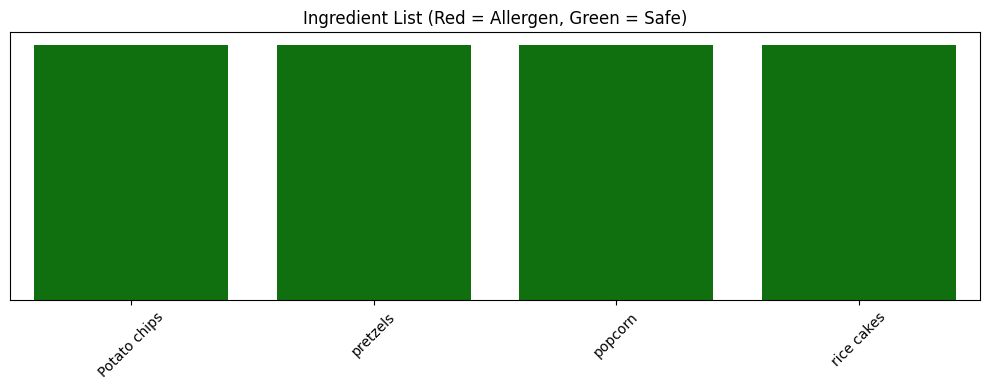

In [15]:
def main():
    user_ingredients = input("Enter ingredient list (comma separated): ").strip()
    user_category = input("Enter food category (e.g., Snacks, Beverages): ").strip()

    print("\n[Step 1] Detecting allergens...")
    detected_allergens = detect_allergens(user_ingredients)
    print("✅ Detected Allergens:", detected_allergens)

    print("\n[Step 2] Suggesting the best safe alternative product...")
    best_alternative = suggest_best_alternative(detected_allergens, df_filtered, user_category)
    print("✅ Best Safe Alternative Product:", best_alternative)

    visualize_ingredients_allergy(user_ingredients, detected_allergens)

if __name__ == '__main__':
    main()

In [ ]:
from transformers import AutoModel, AutoTokenizer

# ✅ New model name (Change it to anything relevant)
MODEL_NAME = "allergen-detection-bert"

def save_model():
    """
    Downloads and saves the model & tokenizer locally for later use.
    """
    print(f"Downloading & saving the model: {MODEL_NAME}")

    # Load Model & Tokenizer
    model = AutoModel.from_pretrained("sgarbi/bert-fda-nutrition-ner")  # Using original source model
    tokenizer = AutoTokenizer.from_pretrained("sgarbi/bert-fda-nutrition-ner")

    # Define save paths with new name
    model_path = f"./{MODEL_NAME}_model"
    tokenizer_path = f"./{MODEL_NAME}_tokenizer"

    # Save Model & Tokenizer
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(tokenizer_path)

    print(f"✅ Model & Tokenizer saved successfully as '{MODEL_NAME}'!")

def load_model():
    """
    Loads the saved model & tokenizer for use in Flask API.
    """
    print(f"Loading the saved model: {MODEL_NAME}...")

    # Load Model & Tokenizer
    model = AutoModel.from_pretrained(f"./{MODEL_NAME}_model")
    tokenizer = AutoTokenizer.from_pretrained(f"./{MODEL_NAME}_tokenizer")

    print("✅ Model & Tokenizer loaded successfully!")
    return model, tokenizer

# Run to save the model with a new name
save_model()


Some weights of BertModel were not initialized from the model checkpoint at sgarbi/bert-fda-nutrition-ner and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model & Tokenizer saved successfully as 'allergen-detection-bert'!
